# Machine Learning Project
## Predicting Good Loans From Lending Club Loan Data  

**Project proposal**

In this project, I am going to build a model to predict whether approve or reject new loan applications based on the historical datasets. I will be using the publicly available dataset of Lending Club issued loan data from 2007 to 2016 Q1. 

I will approach this as a categorial problem by classifying the 'grade' variable into Good and Bad to indicate applicants' risk and treat the binary variable as my response variable. My model should return Good or Bad when evaluating new applicants. 

I'm planning to first clean my data, then implement either PCA or LDA to reduce the 110 dimensions to 10 in order to find interesting variables. After that, I'm going to investigate what variables have significant influences between good applicants and bad applicants. Then I will apply models like random forest to train my data, with cross validation to test. 

# Data Exploration

## Load data
**Data resource: Lending Club** https://www.lendingclub.com/info/download-data.action

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from IPython.display import HTML
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [483]:
# Load data of loan issued by Lending Club from 2007 to 2015. 
loans_issued_2007_2011 = pd.read_csv('Loan_issued_2007_2011.csv', skiprows = 1)
loans_issued_2012_2013 = pd.read_csv('Loan_issued_2012_2013.csv', skiprows = 1)
loans_issued_2014 = pd.read_csv('Loan_issued_2014.csv', skiprows = 1)
loans_issued_2015 = pd.read_csv('Loan_issued_2015.csv', skiprows = 1)
loans_issued_2016Q1 = pd.read_csv('Loan_issued_2016Q1.csv', skiprows = 1)

# Merge the datasets into one 
loans_issued = pd.concat([loans_issued_2007_2011, loans_issued_2012_2013, loans_issued_2014, loans_issued_2015, loans_issued_2016Q1], ignore_index=True)

In [ ]:
# Load data of loan rejected by Lending Club from 2007 to 2015.
loans_rejected_2007_2012 = pd.read_csv('Declined_loan_2007_2012.csv', skiprows = 1)
loans_rejected_2013_2014 = pd.read_csv('Declined_loan_2013_2014.csv', skiprows = 1)
loans_rejected_2015 = pd.read_csv('Declined_loan_2015.csv', skiprows = 1)
loans_rejected_2016Q1 = pd.read_csv('Declined_loan_2016Q1.csv', skiprows = 1)

# Merge the datasets into one
loans_rejected = pd.concat([loans_rejected_2007_2012, loans_rejected_2013_2014, loans_rejected_2015, loans_rejected_2016Q1], ignore_index=True)

In [484]:
loans_issued.shape

(1021280, 111)

Drop variables with lots of missing values

In [507]:
loan = loans_issued.dropna(axis=1, thresh=1021280-50000)

### Convert loan objects to floats
The values in the loan status variable:

>**Current:** Loan is up to date on all outstanding payments. 

>**In Grace Period:** Loan is past due but within the 15-day grace period. 
 
>**Late (16-30):** Loan has not been current for 16 to 30 days. Learn more about the tools Lending Club has to deal with delinquent borrowers.
 
>**Late (31-120):** Loan has not been current for 31 to 120 days. Learn more about the tools Lending Club has to deal with delinquent borrowers.
 
>**Fully paid:** Loan has been fully repaid, either at the expiration of the 3- or 5-year year term or as a result of a prepayment.
 
>**Default:** Loan has not been current for 121 days or more. Learn more about the difference between “default” and “charge off”.
 
>**Charged Off:** Loan for which there is no longer a reasonable expectation of further payments. 

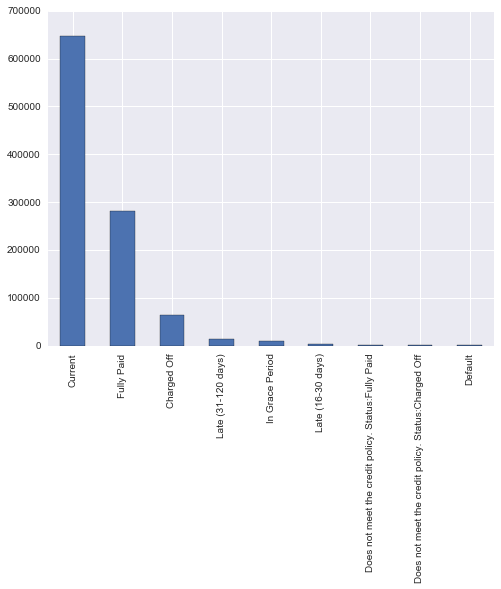

In [486]:
loan['loan_status'].value_counts().plot(kind='bar', figsize=(8,6))

#### Convert loan_status values into two indicators: 

>1: Good Status

>0: Bad Status

In [508]:
# remove current and other trivial values
status = ['Fully Paid', 'Charged Off', 'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)', 'Default']
loan = loan[loan['loan_status'].isin(status)]

# assign 1 to good status and 0 for bad status
loan['loan_status'] = loan.apply(lambda row: 1 if row['loan_status'] == 'Fully Paid' else 0, axis=1)

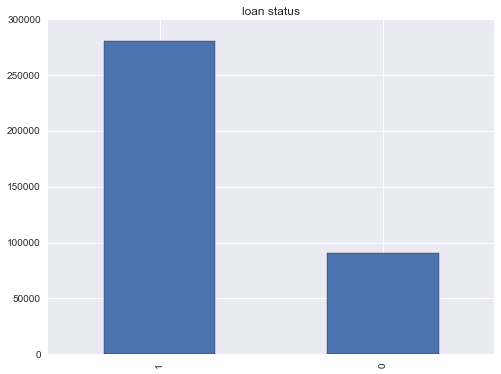

In [489]:
plt.figure(figsize=(8,6))
loan['loan_status'].value_counts().plot(kind='bar', title='loan status', figsize=(8,6))

#### I don't need all of the variables since many of them are post approve loan data. For the purpose of the approval prediction, I will keep potentially interesting data that are known at the time applying for loans.

In [509]:
# store unuseful categorical fetures
issue_date = loan['issue_d']
state = loan['addr_state']
sub_grade = loan['sub_grade']

# drop unhelpful variables
loan.drop(['member_id','sub_grade', 'issue_d', 'title', 'addr_state', 'application_type', 'last_pymnt_d', \
           'pymnt_plan', 'policy_code', 'last_credit_pull_d', 'earliest_cr_line', 'out_prncp', \
           'out_prncp_inv', 'pub_rec_bankruptcies', 'tax_liens', 'url', 'zip_code', 'id', \
           'collections_12_mths_ex_med', 'chargeoff_within_12_mths'], axis=1, inplace=True)

# since 90% of the data is 0, it's not a significant variable, I'm gonna remove this column 
# url is not helpful because the content is a list of websites
# zip code is not helpful because it doesn't have complete code to show
# id works same as membr id
# 99% of collections_12_mths_ex_med is 1
# 99% of chargeoff_within_12_mths is 1
# Remove unuseful categorical variables
# 99% of application_type is individual
# pymnt_plan is not helpful because it only has value 'n' in it.
# all of the policy_code is 1.0

In [510]:
feature_names = ['loan_status', 'purpose', 'loan_amnt', 'annual_inc', 'dti', 'home_ownership', 'verification_status', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'acc_now_delinq', 'delinq_amnt', 'term', 'emp_length', 'revol_util', 'grade', 'initial_list_status']
loan = loan[feature_names]

In [492]:
loan.shape

(370647, 20)

In [493]:
loan.dtypes

loan_status              int64
purpose                 object
loan_amnt              float64
annual_inc             float64
dti                    float64
home_ownership          object
verification_status     object
delinq_2yrs            float64
inq_last_6mths         float64
open_acc               float64
pub_rec                float64
revol_bal              float64
total_acc              float64
acc_now_delinq         float64
delinq_amnt            float64
term                    object
emp_length              object
revol_util              object
grade                   object
initial_list_status     object
dtype: object

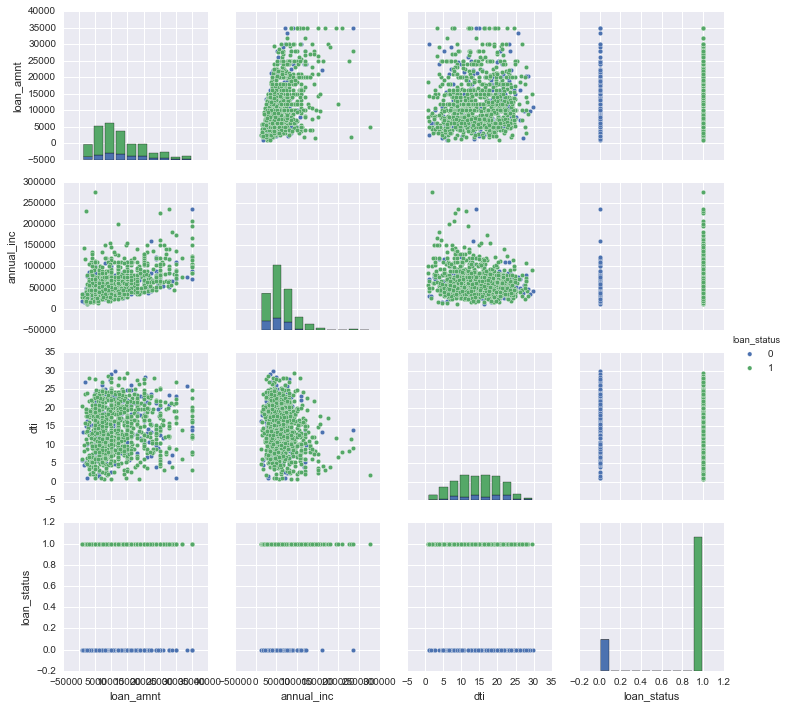

In [42]:
sns.pairplot(loan[['loan_amnt', 'annual_inc', 'dti', 'revol_util', 'loan_status']][:1000], hue="loan_status")

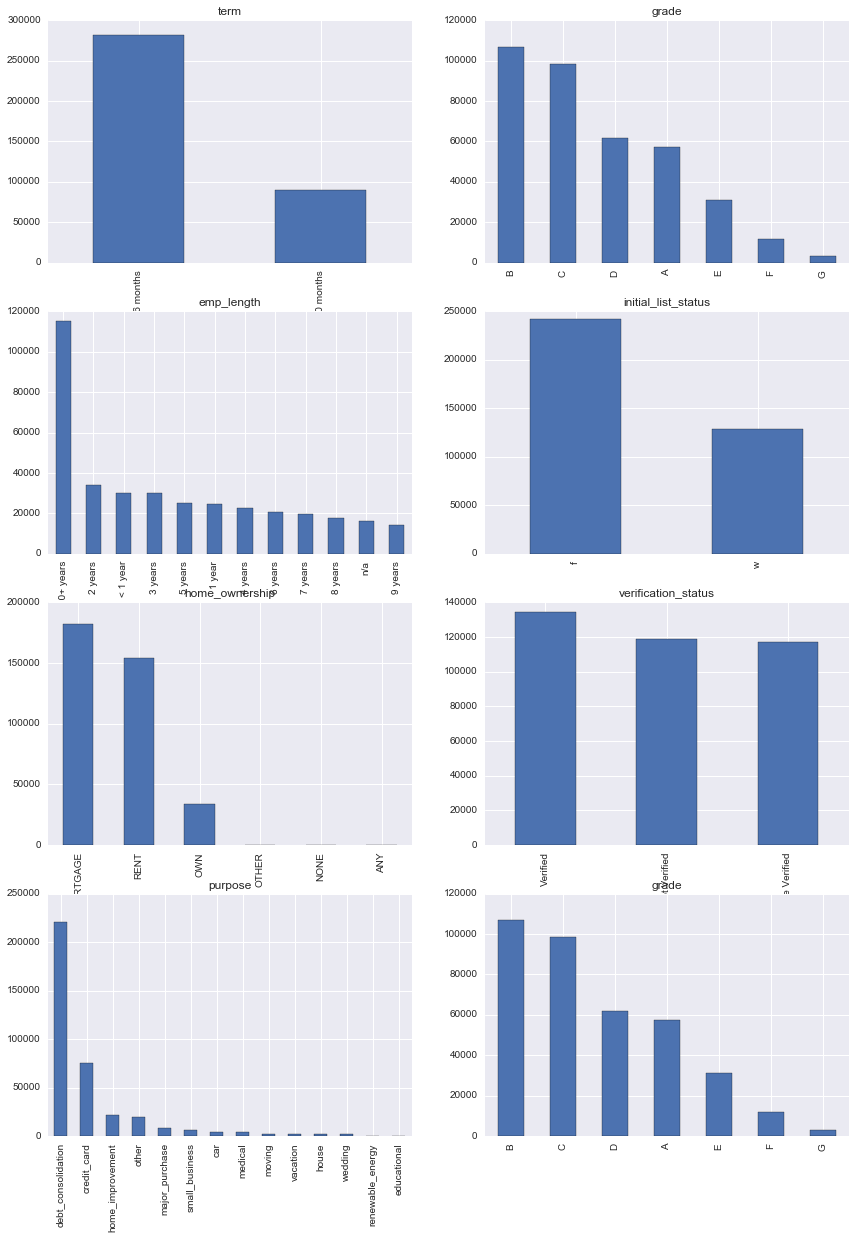

In [232]:
import itertools
import matplotlib.gridspec as gridspec

# For drawing on a grid:
gs = gridspec.GridSpec(4, 4)

# To make a large plot:
plt.figure(figsize=(30,20))

cols = ['term', 'grade', 'emp_length', 'initial_list_status', 'home_ownership', 'verification_status', 'purpose', 'grade']
for i in range(1,9):
    # This picks the correct grid slot:
    ax = plt.subplot(gs[(i-1)/2, (i-1) % 2])
    loan[cols[i-1]].value_counts().plot(kind='bar', title=cols[i-1])


# Data Treatment

### Remove missing values 

In [511]:
# remove 533 rows of NaN values of revol_util
loan = loan[loan['revol_util'].isnull() == False]

# remove one row with the only one NaN value in column inq_last_6mths
loan = loan[loan['inq_last_6mths'].isnull() == False]

In [495]:
loan.isnull().sum()

loan_status            0
purpose                0
loan_amnt              0
annual_inc             0
dti                    0
home_ownership         0
verification_status    0
delinq_2yrs            0
inq_last_6mths         0
open_acc               0
pub_rec                0
revol_bal              0
total_acc              0
acc_now_delinq         0
delinq_amnt            0
term                   0
emp_length             0
revol_util             0
grade                  0
initial_list_status    0
dtype: int64

In [496]:
loan.shape

(370390, 20)

### Convert objects to floats

In [512]:
# Convert emp_length values from string to integers
def adjust_emp_length(row):
    if row['emp_length'] == '10+ years':
        return 10
    elif row['emp_length'] == '9 years':
        return 9
    elif row['emp_length'] == '8 years':
        return 8
    elif row['emp_length'] == '7 years':
        return 7
    elif row['emp_length'] == '5 years':
        return 5
    elif row['emp_length'] == '4 years':
        return 4
    elif row['emp_length'] == '3 years':
        return 3
    elif row['emp_length'] == '2 years':
        return 2
    elif row['emp_length'] == '1 year':
        return 1
    elif row['emp_length'] == '< 1 year':
        return 1    
    else:
        return 0

loan['emp_length_years'] = loan.apply(adjust_emp_length, axis=1)

In [51]:
loan[['emp_length', 'emp_length_years']][:5]

,emp_length,emp_length_years
0,10+ years,10
1,< 1 year,1
2,10+ years,10
3,10+ years,10
5,3 years,3


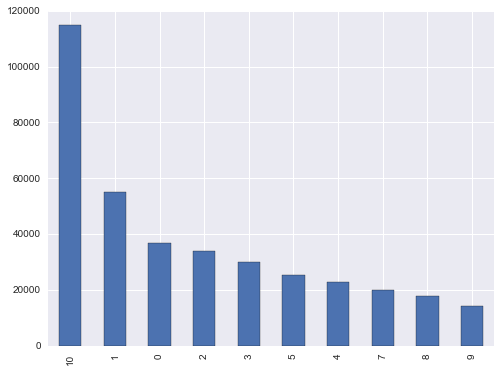

In [52]:
loan['emp_length_years'].value_counts().plot('bar', figsize=(8,6))

In [513]:
## Convert revol_util from string to float
loan['revol_util_rate'] = loan.apply(lambda row: float(row['revol_util'][:-1])/100, axis=1)

In [514]:
loan[['revol_util', 'revol_util_rate']][:5]

,revol_util,revol_util_rate
0,83.7%,0.837
1,9.4%,0.094
2,98.5%,0.985
3,21%,0.210
5,28.3%,0.283


In [518]:
# convert term values from string to integer
loan['term_month'] = loan.apply(lambda row: int(row['term'].split()[0]), axis=1)

In [519]:
loan[['term', 'term_month']].head()

,term,term_month
0,36 months,36
1,60 months,60
2,36 months,36
3,36 months,36
5,36 months,36


In [601]:
loan_encode = loan.copy()
#loan_data = loan.copy()

### Feature Encoding - Modeling Preparation

Encode the categorical features with indicators:

Encode the non-ordinal features: purpose, home_owner initial_list_status with 1 and 0 

Encode the ordinal feature grade, term_months and verification_status as 1 and 0

Encode grade with 1 and 0

>1: 'A', 'B'

>0: 'C', 'D', 'E', 'F', 'G'

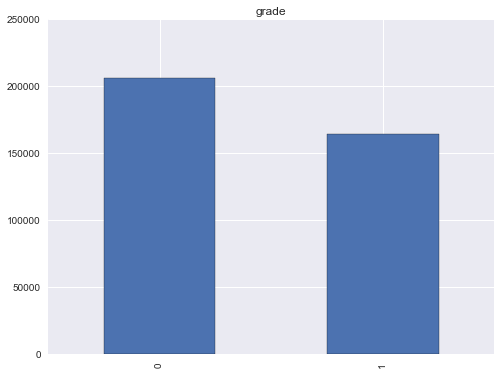

In [602]:
good_grade = ['A', 'B']
loan_encode['grade'] = loan_encode.apply(lambda row: 1 if row['grade'] in good_grade else 0, axis=1)
loan_encode['grade'].value_counts().plot(kind='bar', title='grade', figsize=(8,6))

Encode home_ownership with 1 and 0

>1: 'MORTGAGE', 'OWN'

>0: 'RENT', 'OTHER'

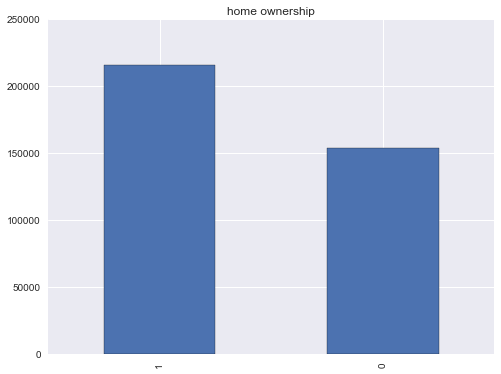

In [603]:
home_own = ['MORTGAGE', 'OWN']
loan_encode = loan_encode[loan_encode['home_ownership'].isin(['MORTGAGE', 'OWN', 'RENT', 'OTHER'])]
loan_encode['home_ownership'] = loan_encode.apply(lambda row: 1 if row['home_ownership'] in home_own else 0, axis=1)
loan_encode['home_ownership'].value_counts().plot(kind='bar', title='home ownership', figsize=(8,6))

Encode verification_status with 1 and 0
>1: 'Verified', 'Source Verified'

>0: 'Not Verified'

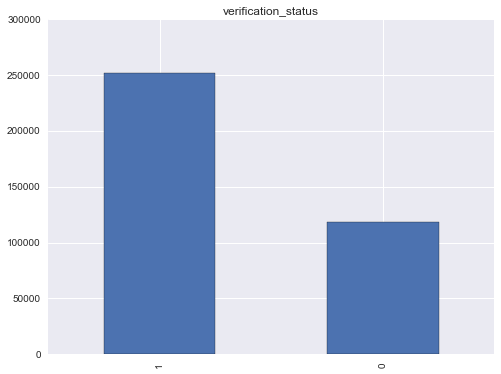

In [604]:
verified = ['Verified', 'Source Verified']
loan_encode['verification_status'] = loan_encode.apply(lambda row: 1 if row['verification_status'] in verified else 0, axis=1)
loan_encode['verification_status'].value_counts().plot(kind='bar', title='verification_status', figsize=(8,6))

Encode the ordinal feature grade as 'A': 7, 'B': 6, 'C': 5, 'D': 4, 'E': 3, 'F': 2, 'G': 1

Encode the ordinal feature initial_list_status as: 
>1: 'w' (whole)

>0: 'f' (fraction)

In [605]:
def initial_list_status_adjust(row):
    if row['initial_list_status'] == 'f':
        return 0 
    else:
        return 1 
    
loan_encode['initial_list_status_values'] = loan_encode.apply(initial_list_status_adjust, axis=1)
loan_encode.drop('initial_list_status', axis=1, inplace=True)

Since term only have values of 60 and 36, I treat them as indicator values with 0 and 1. So encode term as:
>1: 60 months

>0: 36 months

In [606]:
loan_encode['term_month'] = loan_encode.apply(lambda row: 1 if row['term_month'] == 60 else 0, axis=1)

Encode purpose with 1 for debt related payments and 0 for nondebt financing

>1: 'debt_consolidation', 'credit_card'

>0: 'home_improvement', 'major_purchase', etc

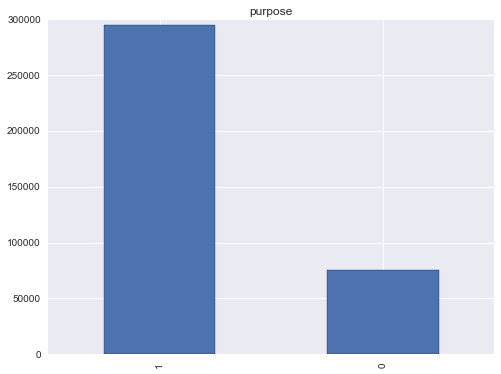

In [607]:
purpose_debt = ['debt_consolidation', 'credit_card']
loan_encode['purpose'] = loan_encode.apply(lambda row: 1 if row['purpose'] in purpose_debt else 0, axis=1)
loan_encode['purpose'].value_counts().plot(kind='bar', title='purpose', figsize=(8,6))

In [608]:
# drop the original object columns
loan_encode.drop(['term', 'emp_length', 'revol_util'], axis=1, inplace=True)

#### There are many post-approve features. Since my goal is to have the model to approve and decline new loan applicantions, I'm going to take interesting features from labels that are known when applying for loans. 

In [609]:
loan_train = loan_encode
y = loan_encode['loan_status']

loan_train.drop('loan_status', axis=1, inplace=True)

In [529]:
loan_encode.to_csv("loan_clean.csv")

# Data Modeling

## Dimensionality Reduction - Modeling Preparation

Dimension reduction methods:
>Principal Component Analysis

>Fisher's Linear Discriminant Analysis

>Radom Forest Classifier 

### PCA Dimensionality Reduction

**Use PCA loadings to determine which features are useful and which can be left out.**

Since PCA doesn't do well on categorical variables, I will be using PCA on determining which continuous variables are important

In [544]:
# take continuous variables only
pca_loan_data = loan_train[['loan_amnt', 'annual_inc', 'dti', 'revol_bal', 'revol_util_rate']]

In [545]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()

# scale and transform the data
loan_scale = scaler.fit_transform(pca_loan_data)

# run PCA with 5 components
pca = PCA(n_components=2)
loan_pca = pca.fit_transform(loan_scale)

Note: the percentage increases largely after removing encoded categorical varialbes

In [546]:
# percentage of variance explained by each of the two components
pca.explained_variance_ratio_

array([ 0.33763555,  0.22438305])

Print features with their loadings / feature importance ratios based on the first component

In [535]:
HTML(pd.DataFrame(sorted(zip(map(lambda x: abs(round(x, 4)),pca.components_[0]), pca_loan_data.columns), reverse=True)).to_html())

,0,1
0,0.5779,revol_bal
1,0.5602,loan_amnt
2,0.5102,annual_inc
3,0.2989,revol_util_rate
4,0.0503,dti


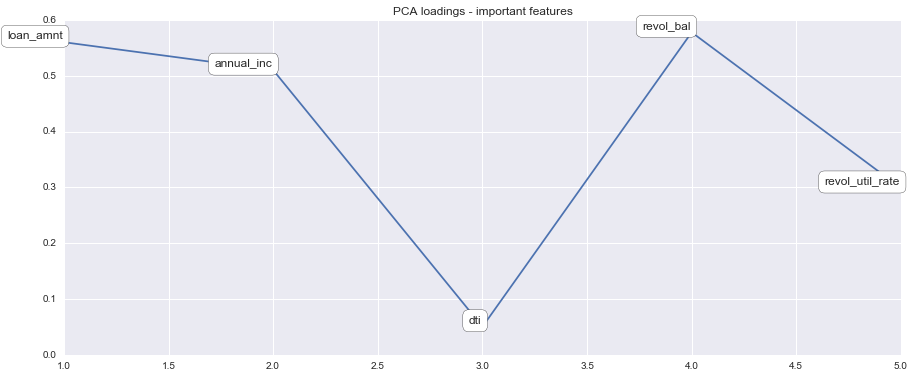

In [536]:
for label, x, y in zip(pca_loan_data.columns, range(1,6), abs(pca.components_[0])):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (-1, 1),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white'),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0.2')
    )
    
plt.plot(range(1,6), abs(pca.components_[0]), marker="+")
plt.title('PCA loadings - important features')

the components don't explain much about variance, does it mean pca doesn't work well in this case? how to interpret the plot?

In [152]:
#from sklearn.feature_selection import chi2
#chi2(X_train, Y_train)

### LDA Dimensionality Reduction

In [548]:
from sklearn.lda import LDA
lca = LDA(n_components=2)
loan_lca = lca.fit_transform(loan_scale, y)
HTML(pd.DataFrame(sorted(zip(abs(lca.coef_[0]), pca_loan_data.columns),reverse=True)).to_html())

,0,1
0,0.253834,loan_amnt
1,0.215679,revol_util_rate
2,0.152815,annual_inc
3,0.133563,dti
4,0.104405,revol_bal


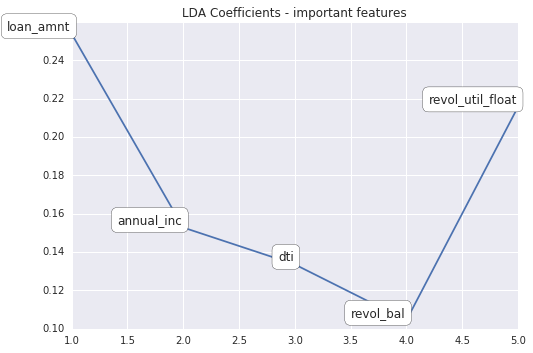

In [790]:
for label, x, y in zip(pca_loan_data.columns, range(1,6), abs(lca.coef_[0])):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (-1, 1),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white'),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0.2')
    )
    
plt.plot(range(1,6), abs(lca.coef_[0]))
plt.title('LDA Coefficients - important features')

### Radom Forest Classifier - Feature Selection

**Use feature importance ratios of Random Forest Classifier to determine which features are useful.**

In [590]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10, bootstrap=True, oob_score=True, random_state=10)
rf.fit(loan_train.values, y.values)
HTML(pd.DataFrame(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), loan_train.columns), reverse=True)).to_html())

,0,1
0,0.1373,dti
1,0.1259,revol_bal
2,0.1251,revol_util_rate
3,0.1114,annual_inc
4,0.1022,loan_amnt
5,0.0935,total_acc
6,0.0788,open_acc
7,0.0550,emp_length_years
8,0.0385,grade
9,0.0337,inq_last_6mths


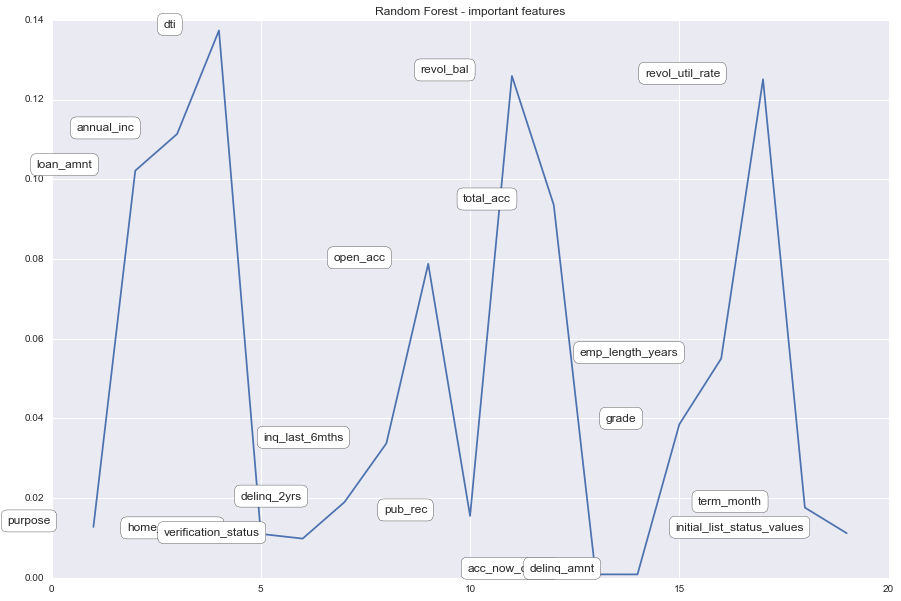

In [592]:
plt.figure(figsize=(15, 10))
for label, x, y in zip(loan_train.columns, range(0,20), abs(rf.feature_importances_)):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (-1, 1),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white'),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0.2')
    )
    
plt.plot(range(1,20), abs(rf.feature_importances_))
plt.title('Random Forest - important features')

### Plot the correlation matrix.

In [32]:
loan_train['loan_status'] = loan_encode['loan_status']

/Users/muxinshang/anaconda/envs/logit/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


/Users/muxinshang/anaconda/envs/logit/lib/python2.7/site-packages/seaborn/linearmodels.py:1285: UserWarning: The `corrplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `corrplot` function has been deprecated in favor "
/Users/muxinshang/anaconda/envs/logit/lib/python2.7/site-packages/seaborn/linearmodels.py:1351: UserWarning: The `symmatplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `symmatplot` function has been deprecated in favor "


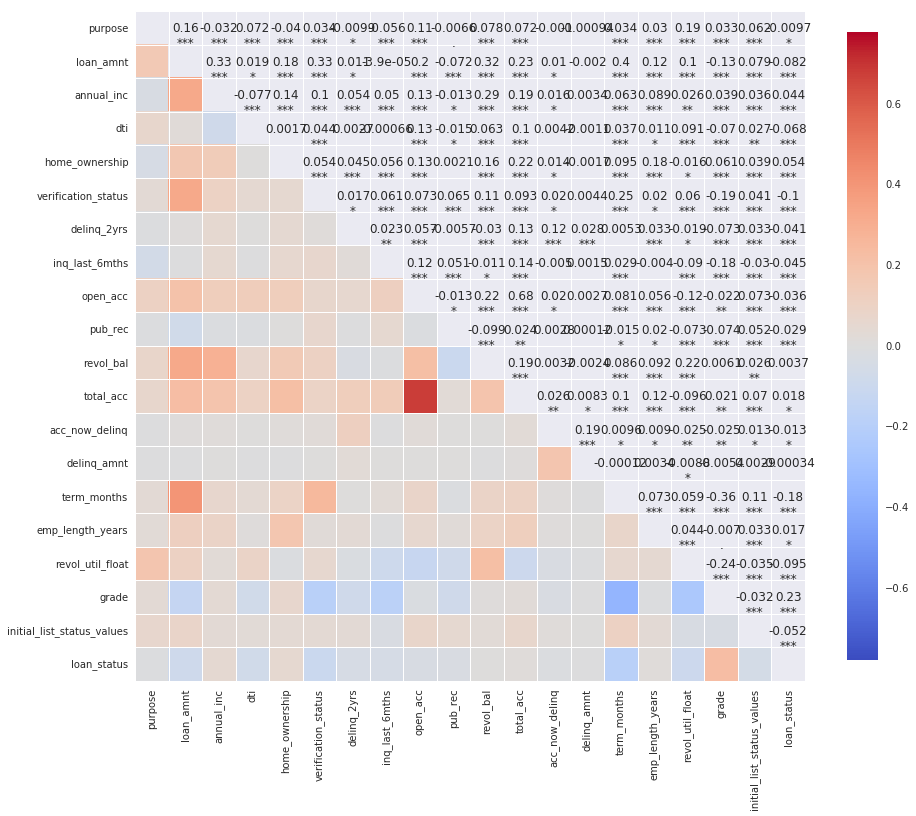

In [685]:
import seaborn as sns 

# Specify the plot dimensions:
fig, ax = plt.subplots(figsize=(15, 15))

sns.corrplot(loan_train, ax=ax, diag_names=False)

In [593]:
loan_train.corr().apply(np.round, decimals=2)

,purpose,loan_amnt,annual_inc,dti,home_ownership,verification_status,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,acc_now_delinq,delinq_amnt,grade,emp_length_years,revol_util_rate,term_month,initial_list_status_values
purpose,1.00,0.16,-0.03,0.07,-0.04,0.03,-0.01,-0.06,0.11,-0.01,0.08,0.07,-0.00,-0.00,0.03,0.03,0.19,0.03,0.06
loan_amnt,0.16,1.00,0.33,0.02,0.18,0.33,0.01,-0.00,0.20,-0.07,0.32,0.23,0.01,-0.00,-0.13,0.12,0.10,0.40,0.08
annual_inc,-0.03,0.33,1.00,-0.08,0.14,0.10,0.05,0.05,0.13,-0.01,0.29,0.19,0.02,0.00,0.04,0.09,0.03,0.06,0.04
dti,0.07,0.02,-0.08,1.00,0.00,0.04,0.00,-0.00,0.13,-0.01,0.06,0.10,0.00,-0.00,-0.07,0.01,0.09,0.04,0.03
home_ownership,-0.04,0.18,0.14,0.00,1.00,0.05,0.04,0.06,0.13,0.00,0.16,0.22,0.01,-0.00,0.06,0.18,-0.02,0.10,0.04
verification_status,0.03,0.33,0.10,0.04,0.05,1.00,0.02,0.06,0.07,0.06,0.11,0.09,0.02,0.00,-0.19,0.02,0.06,0.25,0.04
delinq_2yrs,-0.01,0.01,0.05,0.00,0.04,0.02,1.00,0.02,0.06,-0.01,-0.03,0.13,0.12,0.03,-0.07,0.03,-0.02,0.01,0.03
inq_last_6mths,-0.06,-0.00,0.05,-0.00,0.06,0.06,0.02,1.00,0.12,0.05,-0.01,0.14,-0.00,0.00,-0.18,-0.00,-0.09,0.03,-0.03
open_acc,0.11,0.20,0.13,0.13,0.13,0.07,0.06,0.12,1.00,-0.01,0.22,0.68,0.02,0.00,-0.02,0.06,-0.12,0.08,0.07
pub_rec,-0.01,-0.07,-0.01,-0.01,0.00,0.06,-0.01,0.05,-0.01,1.00,-0.10,0.02,0.00,0.00,-0.07,0.02,-0.07,-0.01,0.05


### Based on analysis above, I will be using these 4 features: 
>loan_amnt

>annual_inc

>revol_util

>grade

In [610]:
X = loan_train[['loan_amnt', 'annual_inc', 'revol_util_rate', 'grade']]

In [595]:
X['loan_amnt'].describe()

count    370346.000000
mean      13977.866576
std        8277.303708
min         500.000000
25%        7800.000000
50%       12000.000000
75%       19500.000000
max       40000.000000
Name: loan_amnt, dtype: float64

In [596]:
X['annual_inc'].describe()

count    3.703460e+05
mean     7.337654e+04
std      6.270261e+04
min      0.000000e+00
25%      4.500000e+04
50%      6.267650e+04
75%      8.845150e+04
max      8.900060e+06
Name: annual_inc, dtype: float64

(0, 500000)

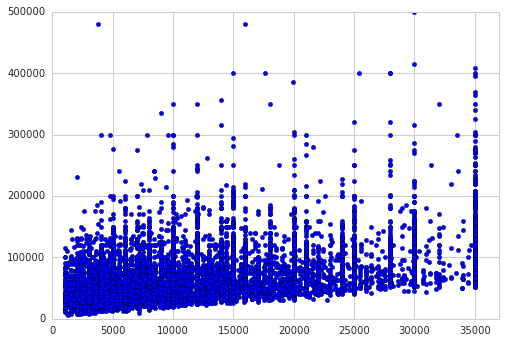

In [123]:
plt.scatter(X['loan_amnt'][:10000].values, X['annual_inc'][:10000].values)
plt.xlim(0,37000)
plt.ylim(0, 500000)

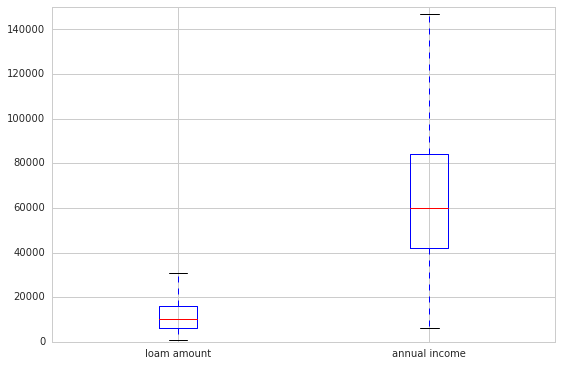

In [138]:
temp=[X['loan_amnt'][:10000].values, X['annual_inc'][:10000].values]
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
plt.boxplot(temp)
plt.ylim(0, 150000)
ax.set_xticklabels(['loam amount', 'annual income']);

## Prediction Models

>Logistic Regression

>Random Forest

>Naive Bayes

>K-Nearest Neighbors

>Support Vector Machine

Create print_classification_metrics function to evaluate the prediction models

In [597]:
from sklearn import metrics
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=None):
    # Normalize confusion matrix
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm_norm, interpolation='nearest', cmap=cmap, vmin=0.0, vmax=1.0)
    plt.title(title)
    plt.colorbar()

    if labels is None:
        labels = range(cm.shape[0])
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def print_classification_metrics(Y_test, Y_pred, Y_prob, labels=None, not_binary=False):
    # Print an accuracy score:
    print "Accuracy %.2f\n" % metrics.accuracy_score(Y_test, Y_pred)

    # Print log-loss score:
    print "Log-loss %.2f\n" % metrics.log_loss(Y_test, Y_prob, eps=1e-15, normalize=True)

    # Print a generic classification report:
    print metrics.classification_report(Y_test, Y_pred)

    cm = metrics.confusion_matrix(Y_test, Y_pred)
    np.set_printoptions(precision=2)

    # Confusion matrix:
    print 'Confusion matrix'
    print cm, "\n"

    # Normalized confusion matrix:
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    print 'Normalized confusion matrix'
    print cm_normalized, "\n"

    # Plot confusion matrix:
    plot_confusion_matrix(cm, labels=labels)
    
    if not not_binary:
        tpr = float(cm[1,1])/cm[1,:].sum()
        print "Sensitivity (TP rate)", tpr
        print "FP rate", 1-tpr
        print ""

        tnr = float(cm[0,0])/cm[0,:].sum()
        print "Specificity (TN rate)", tnr
        print "FN rate", 1-tnr
        print ""

        print "Precision", float(cm[1,1])/cm[:,1].sum()

**Classifier evaluation**: apply Cross Validation and split data into 75% training and 25% testing

In [611]:
# training data with Cross Validation
X = preprocessing.scale(X.values)
y = y.values

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=.25, random_state=2)

### Logistic Regression

In [612]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression()
logit.fit(X_train, Y_train)

Y_prob_logit = logit.predict_proba(X_test)
Y_pred_logit = logit.predict(X_test)
logit_score = logit.score(X_test, Y_test)

In [613]:
print "The accuracy score for the Logistic Regression model is {:.3f}".format(logit_score)

The accuracy score for the Logistic Regression model is 0.755


Accuracy 0.76

Log-loss 0.52

             precision    recall  f1-score   support

          0       0.00      0.00      0.00     22681
          1       0.76      1.00      0.86     69906

avg / total       0.57      0.76      0.65     92587

Confusion matrix
[[    0 22681]
 [    1 69905]] 

Normalized confusion matrix
[[  0.00e+00   1.00e+00]
 [  1.43e-05   1.00e+00]] 



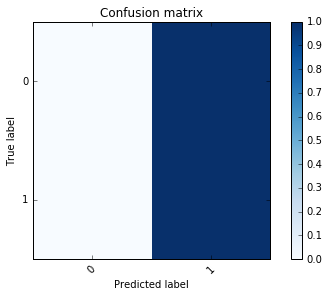

In [45]:
print_classification_metrics(Y_test, Y_pred_logit, Y_prob_logit, not_binary=True)

### Random Forest

In [627]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score

rf_scores = [] 
trees = [10, 100, 500, 1000]

for N in trees:
    # Create Random Forest with N trees:
    forest = RandomForestClassifier(n_estimators=N)
    
    # Train, cross-validate and append score
    # Since the data is shuffled, we take a subset of size of 10000:
    rf_scores.append(np.mean(cross_val_score(forest, X_train[:10000,:], Y_train[:10000], scoring='log_loss', n_jobs=-1)))

print rf_scores
# A larger log-loss score indicates a better model fit.

[-1.8206063338837952, -0.6312674597204978, -0.59599811098174571, -0.59566746221433176]


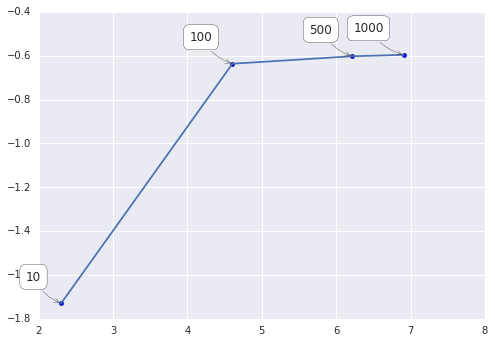

In [740]:
for label, x, y in zip(trees, np.log(trees), rf_scores):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white'),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0.2')
    )
    
plt.plot(np.log([10, 100, 500, 1000]), rf_scores)
#plt.scatter(np.log([10, 100, 500, 1000]), rf_scores)

Take N = 100 becasue it generate good score with simplest model

In [625]:
# Create a new random forest model with 100 trees 
#from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=100, verbose=True, n_jobs=-1, random_state=11)
forest.fit(X_train, Y_train)
forest_prob = forest.predict_proba(X_test)
forest_pred = forest.predict(X_test)
forest_score = forest.score(X_test, Y_test)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    7.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    8.3s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   11.3s finished


In [626]:
print "The accuracy score for the Random Forest model is {:.3f}".format(forest_score)

The accuracy score for the Random Forest model is 0.714


Accuracy 0.71

Log-loss 0.72

             precision    recall  f1-score   support

          0       0.36      0.21      0.26     22681
          1       0.77      0.88      0.82     69906

avg / total       0.67      0.71      0.69     92587

Confusion matrix
[[ 4702 17979]
 [ 8524 61382]] 

Normalized confusion matrix
[[ 0.21  0.79]
 [ 0.12  0.88]] 



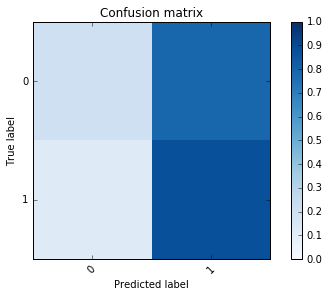

In [48]:
print_classification_metrics(Y_test, forest_pred, forest_prob, not_binary=True)

### Naive Bayes

In [623]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb = nb.fit(X_train, Y_train)
nb_prob = nb.predict_proba(X_test)
nb_pred = nb.predict(X_test)
nb_score = nb.score(X_test, Y_test)

In [624]:
print "The accuracy score for the Naive Bayes model is {:.3f}".format(nb_score)

The accuracy score for the Naive Bayes model is 0.744


In [51]:
#print_classification_metrics(Y_test, nb_prob, nb_pred, not_binary=True)

### K-Nearest Neighbors

**Determine k value by comparing values of k from 1 to 30.**

In [614]:
from sklearn.neighbors import KNeighborsClassifier

k_range = np.arange(1, 31)

k_score = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn = knn.fit(X_train, Y_train)
    knn_pred = knn.predict(X_test)
    k_score.append(knn.score(X_test, Y_test))

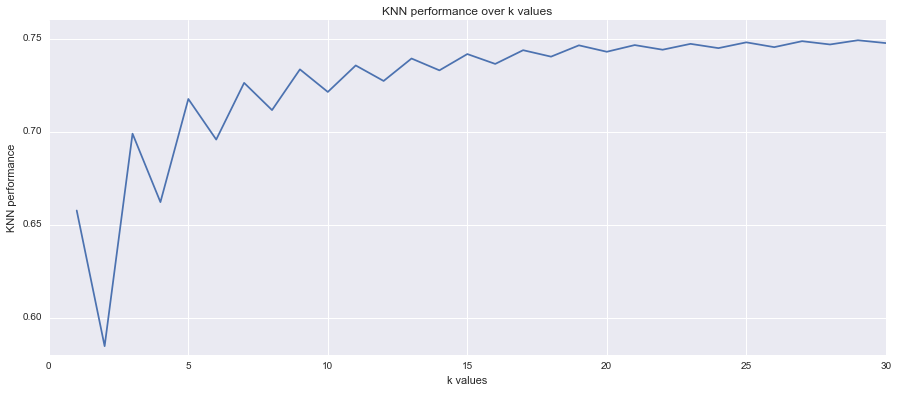

In [615]:
plt.plot(k_range, k_score)
plt.title('KNN performance over k values')
plt.xlabel('k values')
plt.ylabel('KNN performance')

From the graph, I take k = 15 becasue greater values increase complexity and don't make much impact 

In [621]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=15)
knn = knn.fit(X_train, Y_train)
knn_pred = knn.predict(X_test)
knn_score = knn.score(X_test, Y_test)

In [622]:
print "The accuracy score for KNN model is {:.3f}".format(knn_score)

The accuracy score for KNN model is 0.742


### Support Vector Machine

Run through various SVM models with different c values and rbf kernel

from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV

parameters = {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf']}

svc = SVC(C=1) 

hyper_model = GridSearchCV(svc, parameters, n_jobs=-1, scoring="accuracy", cv=2, verbose=1)

hyper_model.fit(X_train, Y_train) 

In [616]:
from sklearn.svm import SVC

c_range = [0.01, 0.1, 1, 10, 100]

svc_score = []

for c in c_range:
    svc = SVC(C=c)
    svc = svc.fit(X_train[:10000, :], Y_train[:10000])
    svc_pred = svc.predict(X_test)
    svc_score.append(svc.score(X_test, Y_test))

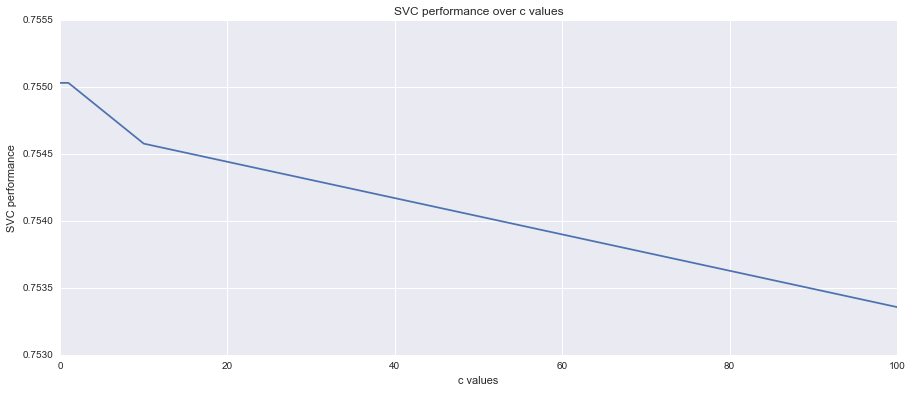

In [617]:
plt.plot(c_range, svc_score)
plt.title('SVC performance over c values')
plt.xlabel('c values')
plt.ylabel('SVC performance')

Based on the graph, the best strategy is to take c = 0.1

In [618]:
from sklearn.svm import SVC
svc = SVC(C=0.1)
svc = svc.fit(X_train[:10000, :], Y_train[:10000])

In [619]:
svc_pred = svc.predict(X_test)
svc_score = svc.score(X_test, Y_test)

In [620]:
print "The accuracy score for SVC model is {:.3f}".format(svc_score)

The accuracy score for SVC model is 0.755


fig = pylab.figure()    
ax = fig.add_subplot(1,1,1)
ax.yaxis.grid(color='gray', linestyle='dashed')

## Estimation of Performance

Area under the ROC curve : 0.499993
Area under the ROC curve : 0.542687
Area under the ROC curve : 0.506644
Area under the ROC curve : 0.528949
Area under the ROC curve : 0.500000


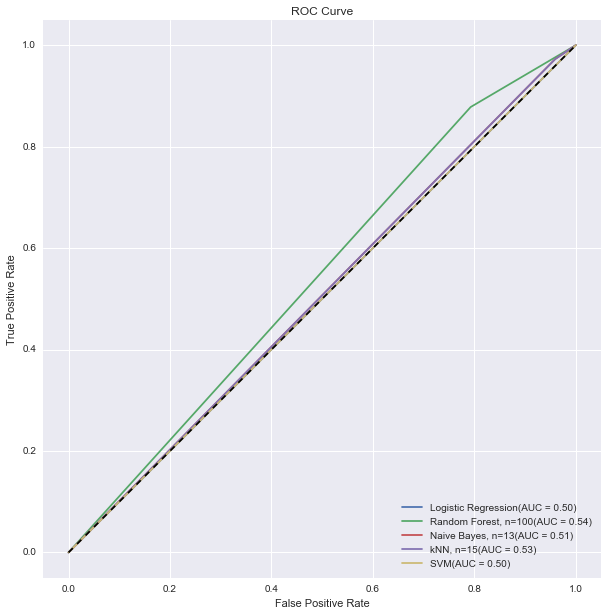

In [628]:
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold

fpr1, tpr1, thresholds =roc_curve(Y_test, Y_pred_logit) 
roc_auc1 = auc(fpr1, tpr1)
print("Area under the ROC curve : %f" % roc_auc1)

fpr2, tpr2, thresholds2 =roc_curve(Y_test, forest_pred)
roc_auc2 = auc(fpr2,tpr2)
print("Area under the ROC curve : %f" % roc_auc2)

fpr3, tpr3, thresholds3 =roc_curve(Y_test, nb_pred)
roc_auc3 = auc(fpr3,tpr3)
print("Area under the ROC curve : %f" % roc_auc3)

fpr4, tpr4, thresholds4 =roc_curve(Y_test, knn_pred)
roc_auc4 = auc(fpr4, tpr4)
print("Area under the ROC curve : %f" % roc_auc4)

fpr5, tpr5, thresholds5 =roc_curve(Y_test, svc_pred)
roc_auc5 = auc(fpr5, tpr5)
print("Area under the ROC curve : %f" % roc_auc5)

### Plot ROC plots
plt.figure(figsize=(10,10))
plt.plot(fpr1,tpr1,label='Logistic Regression(AUC = %0.2f)' % roc_auc1)
plt.plot(fpr2,tpr2,label='Random Forest, n=100(AUC = %0.2f)' % roc_auc2)
plt.plot(fpr3,tpr3,label='Naive Bayes, n=13(AUC = %0.2f)' % roc_auc3)
plt.plot(fpr3,tpr3,label='kNN, n=15(AUC = %0.2f)' % roc_auc4)
plt.plot(fpr5,tpr5,label='SVM(AUC = %0.2f)' % roc_auc5)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

In [89]:
overall_score = [round(x, 3) for x in [logit_score, forest_score, nb_score, knn_score, svc_score]]
AUC = [0.50, 0.54, 0.51, 0.53, 0.50]
models = ['Logistic Regression', 'Random Forest (N=100)', 'Naive Bayes', 'KNN (n=15)', 'SVC (c=0.1)']
result = pd.DataFrame({'Accuracy Score': overall_score, 'AUC': AUC, 'Model': models})

In [90]:
result

,AUC,Accuracy Score,Model
0,0.50,0.755,Logistic Regression
1,0.54,0.714,Random Forest (N=100)
2,0.51,0.744,Naive Bayes
3,0.53,0.742,KNN (n=15)
4,0.50,0.755,SVC (c=0.1)


### From the AUC and Accuracy Score above of each model, the best one is Random Foest with 100 trees because it has the highest AUC value.